<a href="https://colab.research.google.com/github/XiangxiangXu/NFL/blob/main/SideInfo_multihead.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is the "multi-head" story

## Learning With Side Information



## The Experiment



### The hyper-parameters
We start with a few hyper-parameters, $\mathtt{x\_card, s\_card, y\_card}$ are the cardinalities of $\mathcal {X, S, Y}$, and $\mathtt{kb}, \mathtt{k}$ are the feature dimensions $\bar{k}, k$, respectively.

In [ ]:
import numpy as np
import torch

# cardinalities
x_card, s_card, y_card = (8, 3, 3)
sy_card = s_card * y_card

# number of samples
nSamples = 50000

# batch size
batchsize = 256

# number of epochs
nEpochs = 100

kb = s_card - 1
k = 1

### Data Generation
We genearte the data as before, i.e., use a random joint matrix to generating i.i.d. samples.


In [ ]:
# Fixing random state for reproducibility
np.random.seed(20230606)

# randomly pick joint distribution, normalize
p_x_sy = np.random.random([x_card, sy_card])
p_x_sy = p_x_sy / np.sum(p_x_sy)

"""
Generate random discrete samples
"""
def GenerateDiscreteSamples(p_xy, nSamples):
    '''
    generate n samples of (X, Y) pairs, with distribution p_xy
    '''
    (x_card, y_card) = p_xy.shape
    p_xy_vec = p_xy.reshape(-1)
    key = np.random.choice(range(x_card*y_card), nSamples, p=p_xy_vec)

    X = (key / y_card).astype(int)
    Y = (key % y_card)

    return([X, Y])

### The Learning Experiment

Now we generate the dataset using the given model and prepare dataloader for the neural network. In order to use the generator function we designed for two variables, here we define a new variable $\mathtt{SY}$ to contain the information of both $\mathtt{S}$ and $\mathtt{Y}$: $\mathtt{SY} = |\mathcal{Y}| * \mathtt{S} + \mathtt{Y}$.

In [ ]:
[X, SY] = GenerateDiscreteSamples(p_x_sy, nSamples)
# SY = y_card * S + Y
S = (SY / y_card).astype(int)
Y = SY % y_card

import torch.nn.functional as F
Xt = torch.tensor(X)
Xt = F.one_hot(Xt, x_card).type(torch.FloatTensor)
Yt_c = torch.tensor(Y) # categorical
Yt = F.one_hot(Yt_c, y_card).type(torch.FloatTensor) # one-hot

St_c = torch.tensor(S) # categorical
St = F.one_hot(St_c, s_card).type(torch.FloatTensor) # one-hot

from torch.utils.data import TensorDataset, DataLoader

ds = TensorDataset(Xt, St, Yt)
dl = DataLoader(ds, batch_size=batchsize, shuffle = True)
#cmp: for comparison
ds_cmp = TensorDataset(Xt, St_c, Yt_c)
dl_cmp = DataLoader(ds_cmp, batch_size=batchsize, shuffle = True)

Now we train a neural network to learn the features. Here, since the data is categorical and very small, we can use a single fully-connected layer to generate any function needed. We don't need to use a non-linear activation here for the same reason. If we insist to add an activaton function, the result would be the same, except that we have to be careful when reading out the learned feature functions to include the non-linear operation.

As planned, we will only use 1 node in the hidden layer, $\mathtt {hdim}=1$. For fully connected linear layers, the learned feature functions are precisely the trained weights of these layers. If the network is a bit more complexed, then we will need to use better ways to read out the training results.

### Packaging the Sub-Networks

As before, we pack the four sub-networks for features $\bar{f}$, $f$, $\bar{g}$, $g$, and define $\mathtt{fg\_nn\_side}$. Note that $g$ should be joint functions of $s$ and $y$.

In [ ]:
from torch import nn, optim

class fc_net(nn.Module): # fully connected
    def __init__(self, fdim, num_classes):
        super().__init__()
        self.fc = nn.Linear(num_classes, fdim)

    def forward(self, x):
        f = self.fc(x)
        return f

class fc_net_kron(nn.Module):
    # fully connected, with kronecker product of two variables as the input
    def __init__(self, fdim, num_classes):
        super().__init__()
        self.fc = nn.Linear(num_classes, fdim)

    def forward(self, x12):
        x1, x2 = x12
        x1x2 = torch.stack([torch.kron(x1[i], x2[i]) for i in range(len(x1))])
        # row-wise kronecker product:
        #     to convert (x1, x2) into x1 * x2_card + x2
        f = self.fc(x1x2)
        return f

class fg_nn_side(nn.Module):
    def __init__(self, fb_net, gb_net, f_net, g_net):
        super().__init__()

        self.fb_net = fb_net
        self.gb_net = gb_net
        self.f_net = f_net
        self.g_net = g_net

    def forward(self, x, s, y):
        fb = self.fb_net(x)
        gb = self.gb_net(s)
        f = self.f_net(x)
        g = self.g_net([s, y])
        return fb, gb, f, g

    def get_fb(self, x):
        fb = self.fb_net(x)
        return fb

    def get_f(self, x):
        f = self.f_net(x)
        return f

    def get_gb(self, s):
        gb = self.gb_net(s)
        return gb

    def get_g(self, sy):    #sy: (s, y)
        g = self.g_net(sy) # (s, y)
        return g

fb_net = fc_net(kb, x_card)
gb_net = fc_net(kb, s_card)
f_net = fc_net(k, x_card)
g_net = fc_net_kron(k, sy_card)

model = fg_nn_side(fb_net, gb_net, f_net, g_net)
opt = optim.Adam(model.parameters())

### Nested H-Score for Side Infomation

The key is in the definition of $\mathtt{neg\_hscore\_nest\_side}$, where we define the loss function as the sum of two H-scores of nested input features.

In [ ]:
centralize = lambda x: x - torch.mean(x, 0) # zero-mean
cov = lambda x: x.T @ x / (x.size()[0]-1.) # covariance

def neg_hscore(f, g):
    """
    compute the negative h-score
    """
    f0 = centralize(f)
    g0 = centralize(g)
    corr = torch.mean(torch.sum(f0*g0, 1))
    # to generate zero-mean f, g
    cov_f = cov(f)
    cov_g = cov(g)
    return - corr + torch.trace(cov_f @ cov_g) / 2.

def neg_hscore_nest_side(fb, gb, f, g):
    """
    compute the (nagative) nested H-score:

    from dim0
    """
    res = neg_hscore(fb, gb)
    res += neg_hscore(torch.cat([fb, f], axis = 1), torch.cat([gb, g], axis = 1))
    return res

### Training, Reading Feature Functions

Again, all the same as before, just the loss changed.

In [ ]:
for epoch in range(nEpochs):
    for x, s, y in dl:
        fb, gb, f, g = model(x, s, y)
        loss = neg_hscore_nest_side(fb, gb, f, g)
        loss.backward()
        opt.step()
        opt.zero_grad()

# trained values
f_trained = model.get_f(torch.eye(x_card)).detach().numpy()
g_trained_list = []
for s in range(s_card):
    g_trained_list += [model.get_g([torch.eye(s_card)[s] * torch.ones(y_card, 1), torch.eye(y_card)]).detach().numpy()]

This is for our multihead story.

In [ ]:
from torch import nn, optim

class twolayerfc_s(nn.Module):
    # with shared Representation f(x)
    def __init__(self, hdim, x_card, s_card, y_card):
        super().__init__()
        self.hidden_layer = nn.Linear(x_card, hdim)
        self.output_layer = nn.ModuleList([nn.Linear(hdim, y_card) for i in range(s_card)])
        # generate s different "head" for each s

    def forward(self, x, s):
        # output for network-s, s is a scalar
        f = self.hidden_layer(x)
        output = self.output_layer[s](f)
        return output

model_cmp = twolayerfc_s(k, x_card, s_card, y_card)
opt = optim.Adam(model_cmp.parameters())
loss_fn = nn.CrossEntropyLoss(reduction='sum')
# to gurantee the correct weighting

for epoch in range(nEpochs):
    for x_, s_, y_ in dl_cmp:
        # since the predicited probablity is normalized for each s, we need to
        # compute cross_entropy for each s separately
        loss = 0
        for s in range(s_card):
            # group the training samples by the s value
            x = x_[s_ == s]
            y = y_[s_ == s]
            y_pred = model_cmp(x, s)
            loss += loss_fn(y_pred, y)
            # the loss for all different s
        loss.backward()
        opt.step()
        opt.zero_grad()

    #print('training neg_h_score =', loss)

# trained values
f_trained_cmp = model_cmp.hidden_layer.weight.detach().numpy()
g_trained_cmp_list = [] # list for all g's
for s in range(s_card):
    g_trained_cmp_list += [model_cmp.output_layer[s].weight.detach().numpy()]

### Plots

Now all we have to do is to compare the feature functions that we computed from the nested H-score, and the ones learned by $|\mathcal{S}|$ different classifiers. We have a $\mathtt{reg\_pair ()}$ function here to turn both functions into standard forms, with zero-mean and unit norm, and a positive inner product between them.

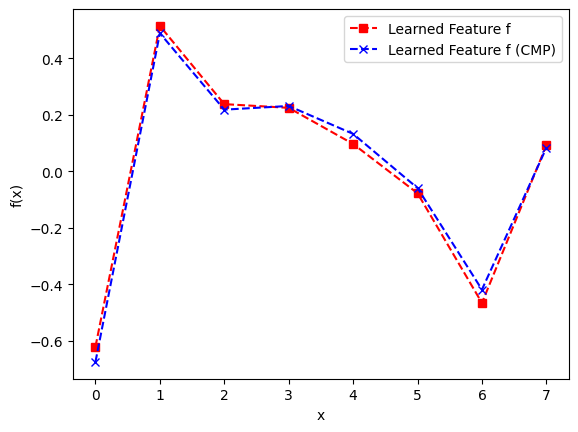

In [ ]:
import matplotlib.pyplot as plt

# regularze to be zero-mean, unit variance under uniform distribution.
def regularize(v):
    v = v.reshape(-1,)
    v = v- v.sum()/v.shape[0]
    v = v / np.sqrt((v*v).sum())
    return v

def reg_pair(v1, v2):
    v1 = regularize(v1)
    v2 = regularize(v2)
    # guarantee <v1, v2> > 0
    sign = np.sign(np.sum(v1 * v2))
    v2 = v2 * sign
    return v1, v2

fig, ax = plt.subplots(1)


f, f_cmp = reg_pair(f_trained, f_trained_cmp)
ax.plot(np.arange(x_card), f, 'rs--', label='Learned Feature f')
ax.plot(np.arange(x_card), f_cmp, 'bx--', label='Learned Feature f (CMP)')
ax.set_xlabel('x')
ax.set_ylabel('f(x)')
ax.legend()

#plt.savefig("f.png")
#files.download("f.png")


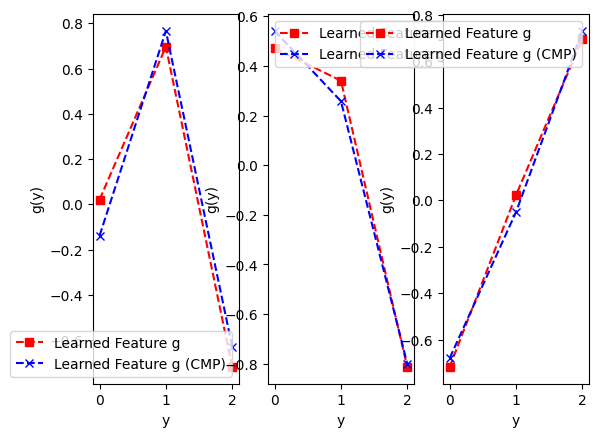

In [ ]:
fig, axs = plt.subplots(1, s_card)
for i in range(s_card):
    g, g_cmp = reg_pair(g_trained_list[i], g_trained_cmp_list[i])
    axs[i].plot(np.arange(y_card), g, 'rs--', label='Learned Feature g')
    axs[i].plot(np.arange(y_card), g_cmp, 'bx--', label='Learned Feature g (CMP)')
    axs[i].set_xlabel('y')
    axs[i].set_ylabel('g(y)')
    axs[i].legend()


#files.download("gs.png")